In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [2]:
import importlib 
import var_net as var_net
import base_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(base_net)



<module 'base_net' from '../src/base_net.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 50 #количество эпох
lamb = [0.001, 0.01, 0.1,  1, 10, 100.0]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_mnist'
lambda_sample_num = 5
lambda_encode = lambda x: (t.log(x) - np.log(0.001))/(np.log(100.) - np.log(0.001))
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)
lambda_encode(lamb[0]), lambda_encode(lamb[-1])

(tensor(0.), tensor(1.0000))

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)





In [16]:
t.manual_seed(0)
kernel_num = 6
for start in range(start_num):                    
        net = var_net.VarNet(base_net.BaseKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma),
             base_net.BaseKernelLayer(hidden_num, 10,   kernel_num, act=lambda x:x, prior_sigma=prior_sigma))

        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = 'epoch {}: '.format(e)                
            utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                  lambda_encode, net, device, loss_fn, optim, label, rep=False, p_gen=lambda p_:p_*5-3)
            if e%5 == 0:
                print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
        t.save(net.state_dict(), os.path.join(path_to_save, 'base_kernel_start_{}.cpk'.format(start)))

epoch 1: [0.3063398 0.3125911]:   1%|          | 2/235 [00:00<00:20, 11.58it/s]

{tensor(0.0010): 0.8083, tensor(0.0100): 0.8599, tensor(0.1000): 0.8513, tensor(1): 0.8605, tensor(10): 0.8682, tensor(100.): 0.8281}


epoch 6: [0.1491364 0.1502553]:   1%|          | 2/235 [00:00<00:19, 11.77it/s]

{tensor(0.0010): 0.9137, tensor(0.0100): 0.9252, tensor(0.1000): 0.9268, tensor(1): 0.9254, tensor(10): 0.9264, tensor(100.): 0.9135}


epoch 11: [0.14084281 0.14936475]:   1%|          | 2/235 [00:00<00:18, 12.47it/s]

{tensor(0.0010): 0.9353, tensor(0.0100): 0.9427, tensor(0.1000): 0.944, tensor(1): 0.942, tensor(10): 0.9426, tensor(100.): 0.9349}


epoch 16: [0.10404097 0.10795504]:   1%|          | 2/235 [00:00<00:19, 11.81it/s]

{tensor(0.0010): 0.9459, tensor(0.0100): 0.9515, tensor(0.1000): 0.9498, tensor(1): 0.9514, tensor(10): 0.9515, tensor(100.): 0.9194}


epoch 21: [0.14783275 0.1636726 ]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9525, tensor(0.0100): 0.9511, tensor(0.1000): 0.9579, tensor(1): 0.9573, tensor(10): 0.9512, tensor(100.): 0.9411}


epoch 26: [0.09449251 0.10046212]:   1%|          | 2/235 [00:00<00:19, 11.87it/s]

{tensor(0.0010): 0.9547, tensor(0.0100): 0.9645, tensor(0.1000): 0.9582, tensor(1): 0.9593, tensor(10): 0.9575, tensor(100.): 0.9308}


epoch 31: [0.07155378 0.07371462]:   1%|          | 2/235 [00:00<00:17, 13.66it/s]

{tensor(0.0010): 0.9619, tensor(0.0100): 0.9644, tensor(0.1000): 0.9596, tensor(1): 0.9643, tensor(10): 0.9554, tensor(100.): 0.954}


epoch 36: [0.07193998 0.07486983]:   1%|          | 2/235 [00:00<00:18, 12.33it/s]

{tensor(0.0010): 0.9655, tensor(0.0100): 0.9662, tensor(0.1000): 0.9634, tensor(1): 0.9643, tensor(10): 0.9651, tensor(100.): 0.9571}


epoch 41: [0.07075316 0.07649272]:   1%|          | 2/235 [00:00<00:18, 12.63it/s]

{tensor(0.0010): 0.9664, tensor(0.0100): 0.9656, tensor(0.1000): 0.9661, tensor(1): 0.9614, tensor(10): 0.9658, tensor(100.): 0.9533}


epoch 46: [0.07029642 0.07629445]:   1%|          | 2/235 [00:00<00:14, 15.57it/s]

{tensor(0.0010): 0.9665, tensor(0.0100): 0.9639, tensor(0.1000): 0.963, tensor(1): 0.9641, tensor(10): 0.9674, tensor(100.): 0.9523}


epoch 1: [0.28812242 0.28990084]:   1%|          | 2/235 [00:00<00:17, 13.61it/s]

{tensor(0.0010): 0.8239, tensor(0.0100): 0.8621, tensor(0.1000): 0.838, tensor(1): 0.8715, tensor(10): 0.8634, tensor(100.): 0.7947}


epoch 6: [0.17976052 0.19122192]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9227, tensor(0.0100): 0.9283, tensor(0.1000): 0.9266, tensor(1): 0.9201, tensor(10): 0.9303, tensor(100.): 0.9193}


epoch 11: [0.13087887 0.13922997]:   1%|          | 2/235 [00:00<00:14, 15.70it/s]

{tensor(0.0010): 0.9376, tensor(0.0100): 0.9448, tensor(0.1000): 0.9388, tensor(1): 0.9384, tensor(10): 0.9474, tensor(100.): 0.9354}


epoch 16: [0.14871545 0.16772339]:   1%|          | 2/235 [00:00<00:18, 12.28it/s]

{tensor(0.0010): 0.9455, tensor(0.0100): 0.951, tensor(0.1000): 0.9541, tensor(1): 0.9524, tensor(10): 0.948, tensor(100.): 0.9422}


epoch 21: [0.10181312 0.10807313]:   1%|          | 2/235 [00:00<00:20, 11.61it/s]

{tensor(0.0010): 0.952, tensor(0.0100): 0.9505, tensor(0.1000): 0.9553, tensor(1): 0.9549, tensor(10): 0.9625, tensor(100.): 0.9467}


epoch 26: [0.08837904 0.09371853]:   1%|          | 2/235 [00:00<00:18, 12.83it/s]

{tensor(0.0010): 0.9588, tensor(0.0100): 0.9594, tensor(0.1000): 0.9544, tensor(1): 0.9622, tensor(10): 0.9645, tensor(100.): 0.9547}


epoch 31: [0.07411768 0.07461031]:   1%|          | 2/235 [00:00<00:16, 14.38it/s]

{tensor(0.0010): 0.9545, tensor(0.0100): 0.9632, tensor(0.1000): 0.9644, tensor(1): 0.9609, tensor(10): 0.9631, tensor(100.): 0.9528}


epoch 36: [0.0796843  0.08701894]:   1%|          | 2/235 [00:00<00:20, 11.59it/s]

{tensor(0.0010): 0.9621, tensor(0.0100): 0.9649, tensor(0.1000): 0.9604, tensor(1): 0.9654, tensor(10): 0.9606, tensor(100.): 0.9475}


epoch 41: [0.07235052 0.08011361]:   1%|          | 2/235 [00:00<00:12, 18.34it/s]

{tensor(0.0010): 0.9624, tensor(0.0100): 0.9631, tensor(0.1000): 0.9578, tensor(1): 0.9675, tensor(10): 0.9673, tensor(100.): 0.9586}


epoch 46: [0.06778098 0.06984117]:   1%|          | 2/235 [00:00<00:19, 12.04it/s]

{tensor(0.0010): 0.9644, tensor(0.0100): 0.964, tensor(0.1000): 0.9639, tensor(1): 0.9674, tensor(10): 0.9684, tensor(100.): 0.9621}


epoch 1: [0.28449768 0.28597915]:   1%|          | 2/235 [00:00<00:18, 12.74it/s]

{tensor(0.0010): 0.8327, tensor(0.0100): 0.8582, tensor(0.1000): 0.8623, tensor(1): 0.8573, tensor(10): 0.847, tensor(100.): 0.8315}


epoch 6: [0.17343366 0.18533912]:   1%|          | 2/235 [00:00<00:15, 14.57it/s]

{tensor(0.0010): 0.917, tensor(0.0100): 0.9178, tensor(0.1000): 0.9303, tensor(1): 0.9291, tensor(10): 0.9313, tensor(100.): 0.9169}


epoch 11: [0.1271844  0.13491866]:   1%|          | 2/235 [00:00<00:19, 12.06it/s]

{tensor(0.0010): 0.936, tensor(0.0100): 0.9409, tensor(0.1000): 0.9396, tensor(1): 0.9452, tensor(10): 0.9435, tensor(100.): 0.9345}


epoch 16: [0.09640568 0.10412862]:   1%|          | 2/235 [00:00<00:16, 14.12it/s]

{tensor(0.0010): 0.9437, tensor(0.0100): 0.9519, tensor(0.1000): 0.9507, tensor(1): 0.9528, tensor(10): 0.9542, tensor(100.): 0.9438}


epoch 21: [0.08924724 0.08964322]:   1%|          | 2/235 [00:00<00:20, 11.55it/s]

{tensor(0.0010): 0.9514, tensor(0.0100): 0.9572, tensor(0.1000): 0.9525, tensor(1): 0.9594, tensor(10): 0.9582, tensor(100.): 0.9533}


epoch 26: [0.07277672 0.07282376]:   1%|          | 2/235 [00:00<00:16, 14.07it/s]

{tensor(0.0010): 0.9582, tensor(0.0100): 0.9609, tensor(0.1000): 0.958, tensor(1): 0.9603, tensor(10): 0.9596, tensor(100.): 0.9497}


epoch 31: [0.07657327 0.08014188]:   1%|          | 2/235 [00:00<00:18, 12.79it/s]

{tensor(0.0010): 0.9555, tensor(0.0100): 0.961, tensor(0.1000): 0.9571, tensor(1): 0.9633, tensor(10): 0.9578, tensor(100.): 0.9546}


epoch 36: [0.07268576 0.0764292 ]:   1%|          | 2/235 [00:00<00:19, 12.06it/s]

{tensor(0.0010): 0.9588, tensor(0.0100): 0.9643, tensor(0.1000): 0.9633, tensor(1): 0.9651, tensor(10): 0.964, tensor(100.): 0.9587}


epoch 41: [0.07316776 0.07744744]:   1%|          | 2/235 [00:00<00:15, 14.99it/s]

{tensor(0.0010): 0.9636, tensor(0.0100): 0.9628, tensor(0.1000): 0.9648, tensor(1): 0.9567, tensor(10): 0.9665, tensor(100.): 0.9523}


epoch 46: [0.07244366 0.07782786]:   1%|          | 2/235 [00:00<00:17, 13.61it/s]

{tensor(0.0010): 0.9632, tensor(0.0100): 0.9692, tensor(0.1000): 0.9647, tensor(1): 0.9641, tensor(10): 0.965, tensor(100.): 0.9612}


epoch 1: [0.2888898 0.2891932]:   1%|          | 2/235 [00:00<00:17, 13.42it/s]

{tensor(0.0010): 0.8363, tensor(0.0100): 0.8664, tensor(0.1000): 0.8551, tensor(1): 0.8568, tensor(10): 0.8609, tensor(100.): 0.8206}


epoch 6: [0.14831586 0.15267935]:   1%|          | 2/235 [00:00<00:17, 13.36it/s]

{tensor(0.0010): 0.9225, tensor(0.0100): 0.9204, tensor(0.1000): 0.9255, tensor(1): 0.9232, tensor(10): 0.9206, tensor(100.): 0.9258}


epoch 11: [0.14912495 0.16179119]:   1%|          | 2/235 [00:00<00:17, 12.98it/s]

{tensor(0.0010): 0.9376, tensor(0.0100): 0.9443, tensor(0.1000): 0.9428, tensor(1): 0.9426, tensor(10): 0.9431, tensor(100.): 0.9367}


epoch 16: [0.10268551 0.10820846]:   0%|          | 1/235 [00:00<00:25,  9.21it/s]

{tensor(0.0010): 0.948, tensor(0.0100): 0.95, tensor(0.1000): 0.951, tensor(1): 0.952, tensor(10): 0.954, tensor(100.): 0.944}


epoch 21: [0.09405152 0.1020154 ]:   1%|          | 2/235 [00:00<00:14, 15.77it/s]

{tensor(0.0010): 0.9558, tensor(0.0100): 0.961, tensor(0.1000): 0.9532, tensor(1): 0.9605, tensor(10): 0.9609, tensor(100.): 0.952}


epoch 26: [0.07045743 0.0710992 ]:   1%|          | 2/235 [00:00<00:19, 12.04it/s]

{tensor(0.0010): 0.9554, tensor(0.0100): 0.9649, tensor(0.1000): 0.9618, tensor(1): 0.9631, tensor(10): 0.9626, tensor(100.): 0.9544}


epoch 31: [0.06223164 0.06321908]:   1%|          | 2/235 [00:00<00:19, 12.05it/s]

{tensor(0.0010): 0.9602, tensor(0.0100): 0.9631, tensor(0.1000): 0.966, tensor(1): 0.9635, tensor(10): 0.964, tensor(100.): 0.9572}


epoch 36: [0.0585346  0.06097607]:   1%|          | 2/235 [00:00<00:20, 11.54it/s]

{tensor(0.0010): 0.9617, tensor(0.0100): 0.9648, tensor(0.1000): 0.9656, tensor(1): 0.9646, tensor(10): 0.9637, tensor(100.): 0.9601}


epoch 41: [0.06136866 0.06636398]:   1%|          | 2/235 [00:00<00:20, 11.40it/s]

{tensor(0.0010): 0.9656, tensor(0.0100): 0.9668, tensor(0.1000): 0.9658, tensor(1): 0.9619, tensor(10): 0.9682, tensor(100.): 0.9597}


epoch 46: [0.0746306  0.08345362]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9632, tensor(0.0100): 0.9636, tensor(0.1000): 0.9585, tensor(1): 0.9708, tensor(10): 0.9607, tensor(100.): 0.9562}


epoch 1: [0.31014767 0.31792393]:   1%|          | 2/235 [00:00<00:22, 10.29it/s]

{tensor(0.0010): 0.8463, tensor(0.0100): 0.8686, tensor(0.1000): 0.8542, tensor(1): 0.8604, tensor(10): 0.8523, tensor(100.): 0.8348}


epoch 6: [0.15165716 0.15454854]:   1%|          | 2/235 [00:00<00:14, 16.21it/s]

{tensor(0.0010): 0.9205, tensor(0.0100): 0.9247, tensor(0.1000): 0.9285, tensor(1): 0.9252, tensor(10): 0.9296, tensor(100.): 0.9194}


epoch 11: [0.12185106 0.12908298]:   1%|          | 2/235 [00:00<00:14, 15.90it/s]

{tensor(0.0010): 0.9354, tensor(0.0100): 0.9348, tensor(0.1000): 0.9421, tensor(1): 0.9389, tensor(10): 0.932, tensor(100.): 0.9374}


epoch 16: [0.09888906 0.102208  ]:   0%|          | 1/235 [00:00<00:23,  9.92it/s]

{tensor(0.0010): 0.9445, tensor(0.0100): 0.949, tensor(0.1000): 0.9508, tensor(1): 0.9495, tensor(10): 0.9485, tensor(100.): 0.9192}


epoch 21: [0.09415893 0.09739921]:   1%|          | 2/235 [00:00<00:17, 13.32it/s]

{tensor(0.0010): 0.9391, tensor(0.0100): 0.9495, tensor(0.1000): 0.9555, tensor(1): 0.9573, tensor(10): 0.9563, tensor(100.): 0.9455}


epoch 26: [0.07286571 0.07537363]:   1%|          | 2/235 [00:00<00:18, 12.48it/s]

{tensor(0.0010): 0.9566, tensor(0.0100): 0.9555, tensor(0.1000): 0.958, tensor(1): 0.9578, tensor(10): 0.962, tensor(100.): 0.9558}


epoch 31: [0.0821941  0.09162978]:   1%|          | 2/235 [00:00<00:15, 14.89it/s]

{tensor(0.0010): 0.9549, tensor(0.0100): 0.9503, tensor(0.1000): 0.9434, tensor(1): 0.9629, tensor(10): 0.9663, tensor(100.): 0.9521}


epoch 36: [0.07619976 0.08545703]:   0%|          | 1/235 [00:00<00:24,  9.54it/s]

{tensor(0.0010): 0.9633, tensor(0.0100): 0.961, tensor(0.1000): 0.9617, tensor(1): 0.963, tensor(10): 0.9674, tensor(100.): 0.9592}


epoch 41: [0.06576348 0.0703552 ]:   1%|          | 2/235 [00:00<00:21, 11.00it/s]

{tensor(0.0010): 0.9615, tensor(0.0100): 0.9603, tensor(0.1000): 0.9642, tensor(1): 0.9616, tensor(10): 0.9687, tensor(100.): 0.9586}


epoch 46: [0.06232521 0.06988008]:   1%|          | 2/235 [00:00<00:13, 16.96it/s]

{tensor(0.0010): 0.9638, tensor(0.0100): 0.9637, tensor(0.1000): 0.965, tensor(1): 0.966, tensor(10): 0.9643, tensor(100.): 0.9622}


epoch 49: [0.05250584 0.05664474]: 100%|██████████| 235/235 [00:20<00:00, 11.42it/s]


In [17]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device),
                     base_net.BaseLayer(hidden_num, 10, device, act=lambda x:x)).to(device)


hnet = var_net.VarNet(base_net.BaseKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma),
             base_net.BaseKernelLayer(hidden_num, 10,   kernel_num, act=lambda x:x, prior_sigma=prior_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'base_kernel_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam), mode='base')
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader), mode='base'))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_base_kernel.json'),'w') as out:
    out.write(json.dumps(lam_results))  

tensor(0.0010) 0
tensor(0.0010) 1
tensor(0.0010) 2
tensor(0.0010) 3
tensor(0.0010) 4
tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1) 0
tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(10) 0
tensor(10) 1
tensor(10) 2
tensor(10) 3
tensor(10) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


(0, 1)

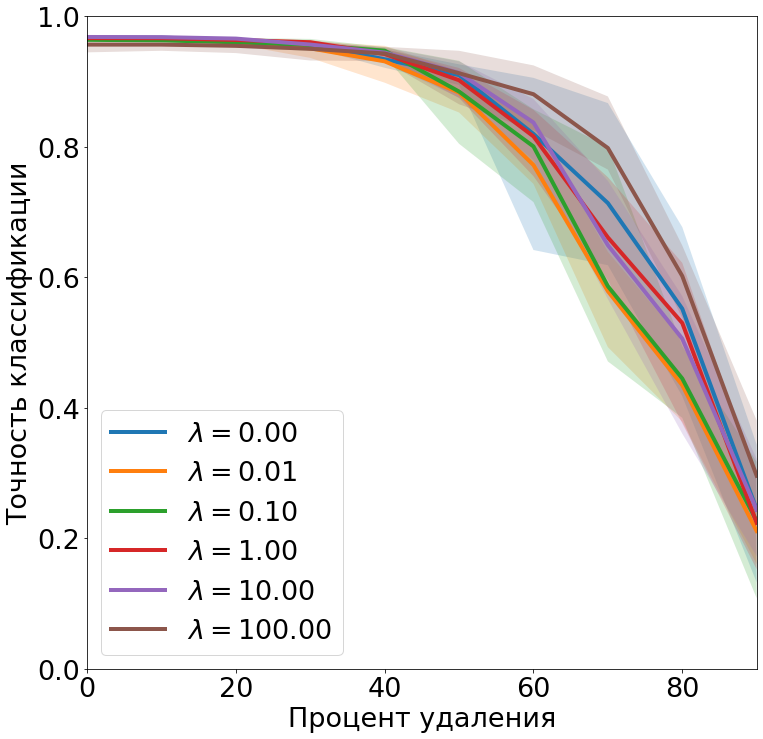

In [18]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Kernel_base')
plt.ylim(0,1)
#plt.show()


In [11]:
utils.test_acc_hyper(hnet, device, test_loader, lambda_encode, [lamb[0.0]])

TypeError: can only concatenate list (not "float") to list